**AZ Watch** is a popular video streaming platform specialized in educational content, where creators publish online video tutorials and lessons about any topic, from speaking a new language to cooking to learning to play a musical instrument.

Their next goal is to leverage AI-driven solutions to analyze and make predictions about their subscribers and improve their marketing strategy around attracting new subscribers and retaining current ones. This project uses machine learning to predict subscribers likely to churn and find customer segments. This may help AZ Watch find interesting usage patterns to build subscriber personas in future marketing plans!

![Woman working on multiple screens](marketinganalytics.jpg)


The `data/AZWatch_subscribers.csv` **dataset** contains information about subscribers and their status over the last year:

|Column name|Description|
|-----------|-----------|
|`subscriber_id`|The unique identifier of each subscriber user|
|`age_group`|The subscriber's age group|
|`engagement_time`|Average time (in minutes) spent by the subscriber per session|
|`engagement_frequency`|Average weekly number of times the subscriber logged in the platform (sessions) over a year period|
|`subscription_status`|Whether the user remained subscribed to the platform by the end of the year period (subscribed), or unsubscribed and terminated her/his services (churned)|

Carefully observe and analyze the features in the dataset, asking yourself if there are any **categorical attributes** requiring pre-processing?

The subscribers dataset from the `data/AZWatch_subscribers.csv` file is already being loaded and split into training and test sets for you:

In [48]:
# Import the necessary modules
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib import pyplot as plt

# Specify the file path of your CSV file
file_path = "data/AZWatch_subscribers.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)
display(df.info())

# Create categorical Ohe data of the age_group column
enc = OneHotEncoder()
cat_cols = ["age_group"]
cat_dt = enc.fit_transform(df[cat_cols])
cat_df = pd.DataFrame(cat_dt.toarray(), columns=enc.get_feature_names_out(cat_cols))

# Separate predictor variables from class label
X = df.drop(['subscriber_id','subscription_status','age_group'], axis=1)
X = pd.concat([X, cat_df], axis=1)
y = df.subscription_status.apply(lambda x: 1 if x == "churned" else 0).values

# Split intro training and test sets (20% test)
X_train, X_test, y_train, y_test = train_test_split(
                        X, y, test_size=.2, random_state=42)

# Scale numeric values
scale_cols = ['engagement_time', 'engagement_frequency']
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train[scale_cols])
X_test_scale = scaler.transform(X_test[scale_cols])

# Convert scaled data back to a df
X_train_df = pd.DataFrame(X_train_scale, columns=scale_cols)
X_test_df = pd.DataFrame(X_test_scale, columns=scale_cols)

# Concatenate data with categorical features
categorical_features = [col for col in X_train.columns if col not in scale_cols]
X_train = pd.concat([X_train_df, X_train[categorical_features].reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test_df, X_test[categorical_features].reset_index(drop=True)], axis=1)

# Check the data
display(X_train.head(),X_test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subscriber_id         1000 non-null   int64  
 1   age_group             1000 non-null   object 
 2   engagement_time       1000 non-null   float64
 3   engagement_frequency  1000 non-null   int64  
 4   subscription_status   1000 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 39.2+ KB


None

,engagement_time,engagement_frequency,age_group_18-34,age_group_35 and over,age_group_under 18
0,-0.441397,-1.126173,0.0,1.0,0.0
1,-1.246811,-0.154462,0.0,1.0,0.0
2,-0.560584,1.465057,0.0,1.0,0.0
3,0.270111,0.007490,0.0,0.0,1.0
4,0.237606,-0.802269,1.0,0.0,0.0


,engagement_time,engagement_frequency,age_group_18-34,age_group_35 and over,age_group_under 18
0,-0.542525,0.979201,1.0,0.0,0.0
1,0.884104,0.655298,0.0,1.0,0.0
2,0.136478,0.007490,1.0,0.0,0.0
3,-0.358328,-0.802269,0.0,1.0,0.0
4,0.609613,0.331394,0.0,0.0,1.0


In [49]:
# instanciate three models 
model1 = LogisticRegression()
model2 = DecisionTreeClassifier()
model3 = RandomForestClassifier()

# train models
model1.fit(X_train,y_train)
model2.fit(X_train,y_train)
model3.fit(X_train,y_train)

# store predictions
pred1 = model1.predict(X_test)
pred2 = model2.predict(X_test)
pred3 = model3.predict(X_test)

# calculate accuracy_scores
acc1 = accuracy_score(y_test, pred1)
acc2 = accuracy_score(y_test, pred2)
acc3 = accuracy_score(y_test, pred3)
print(f'1:{acc1}, 2:{acc2}, 3:{acc3}')
score = acc1

1:0.925, 2:0.87, 3:0.885


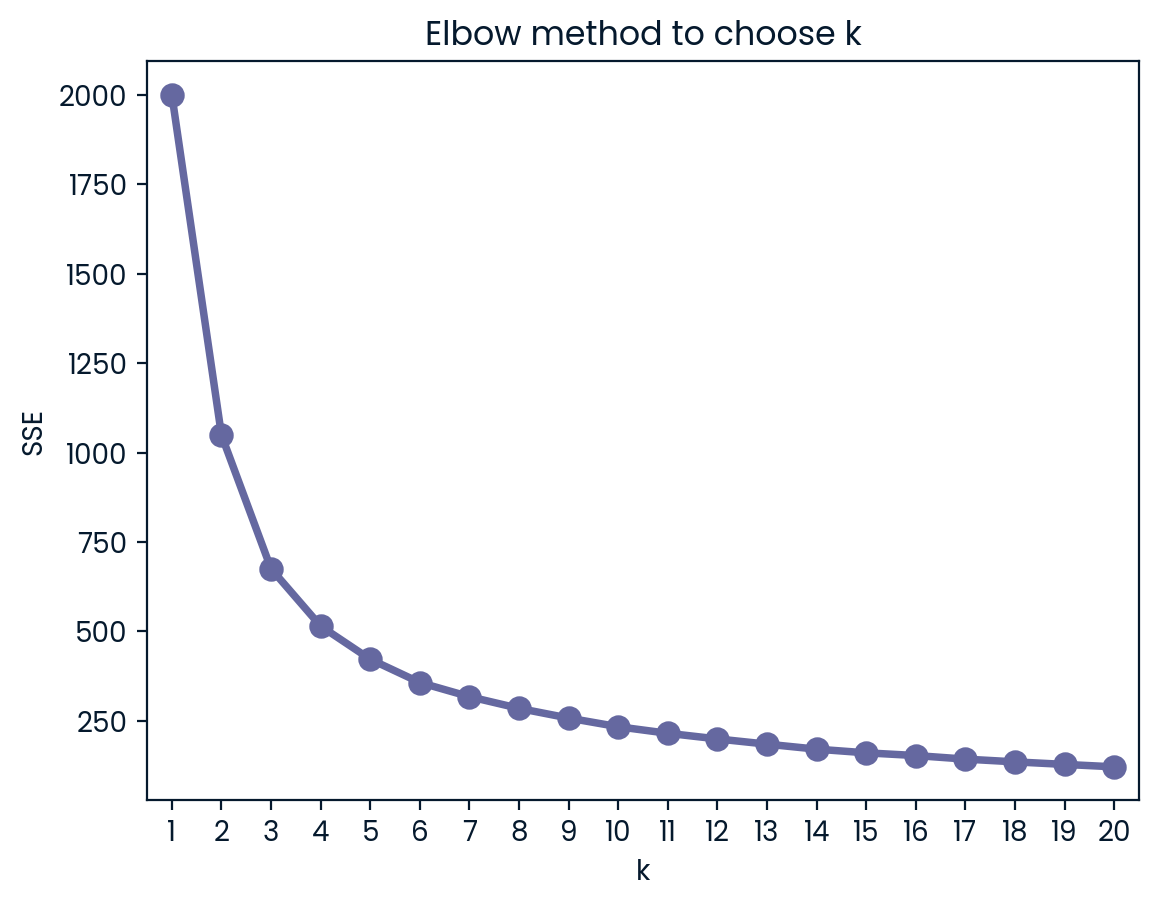

In [50]:
# What subscriber segments can be identified in the data to make their campaigns more targeted?
segmentation = df.drop(columns=['subscriber_id','subscription_status','age_group'])

# scale numerical features
scaler = StandardScaler()
seg_norm = scaler.fit_transform(segmentation)

# calculate data for elbow method
sse = {}
for k in range(1,21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(seg_norm)
    sse[k] = kmeans.inertia_

# create elbow plot
plt.title('Elbow method to choose k')
plt.xlabel('k');plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [51]:
# Add cluster labels as a new attribute in the dataset before scaling
segmentation["cluster_id"] = kmeans.labels_

# Analyze average feature values and counts per cluster
analysis = segmentation.groupby(['cluster_id']).agg({
    'engagement_time': ['mean'],
    'engagement_frequency':['mean']
}).round(0)
display(analysis)

,engagement_time,engagement_frequency
,mean,mean
cluster_id,,
0,6.0,21.0
1,6.0,7.0
2,11.0,18.0
3,9.0,5.0
4,2.0,6.0
5,5.0,14.0
6,3.0,20.0
7,4.0,4.0
